# Clustering

In [8]:
# imports
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
ladf = gpd.read_file('data/Local_Authority_Districts_(December_2020)_UK_BFC.zip!Local_Authority_Districts_(December_2020)_UK_BFC.shp')
ladf

,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.676140,9.371263e+07,71007.443285,"MULTIPOLYGON (((447213.899 537036.104, 447228...."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.388156e+07,44481.691242,"MULTIPOLYGON (((448609.900 521982.600, 448616...."
2,3,E06000003,Redcar and Cleveland,None,464361,519597,-1.00608,54.567520,2.450695e+08,96703.989701,"MULTIPOLYGON (((455932.335 527880.697, 455919...."
3,4,E06000004,Stockton-on-Tees,None,444940,518183,-1.30664,54.556911,2.049330e+08,123408.985928,"MULTIPOLYGON (((444157.002 527956.304, 444165...."
4,5,E06000005,Darlington,None,428029,515648,-1.56835,54.535339,1.974757e+08,107206.401677,"POLYGON ((423496.602 524724.299, 423497.204 52..."
...,...,...,...,...,...,...,...,...,...,...,...
374,375,W06000020,Torfaen,Torfaen,327459,200480,-3.05101,51.698360,1.262399e+08,82544.775967,"POLYGON ((323898.201 211287.499, 324115.698 21..."
375,376,W06000021,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.778271,8.503266e+08,224917.251559,"MULTIPOLYGON (((327830.799 231005.105, 327840...."
376,377,W06000022,Newport,Casnewydd,337897,187432,-2.89769,51.582310,1.904311e+08,153216.416923,"MULTIPOLYGON (((342211.900 194845.495, 342221...."
377,378,W06000023,Powys,Powys,302329,273255,-3.43531,52.348640,5.195311e+09,610132.027463,"POLYGON ((322392.901 334017.198, 322378.002 33..."


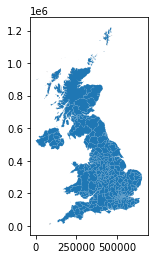

In [9]:
# using https://geopandas.org/en/v0.8.2/mapping.html
ladf.plot()
plt.show()

In [10]:
# get the case data
cases_df = pd.read_csv('data/ltla_caseData.csv')
cases_df.head()

,areaCode,areaName,areaType,date,newCasesByPublishDate,newDeaths28DaysByDeathDate,newPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate
0,E06000003,Redcar and Cleveland,ltla,2021-12-28,238.0,NaN,NaN,NaN
1,E07000040,East Devon,ltla,2021-12-28,243.0,NaN,NaN,NaN
2,E07000090,Havant,ltla,2021-12-28,232.0,NaN,NaN,NaN
3,E07000214,Surrey Heath,ltla,2021-12-28,154.0,NaN,NaN,NaN
4,E07000229,Worthing,ltla,2021-12-28,167.0,NaN,NaN,NaN


In [11]:
# get the census data
census_df = pd.read_csv("districtCensusData.csv")
census_df.head()

,geography,geography_code,dwelling_type_all_categories_accommodation_type,dwelling_type_unshared_dwelling_total,dwelling_type_unshared_dwelling_whole_house_or_bungalow_total,dwelling_type_unshared_dwelling_whole_house_or_bungalow_detached,dwelling_type_unshared_dwelling_whole_house_or_bungalow_semi-detached,dwelling_type_unshared_dwelling_whole_house_or_bungalow_terraced_(including_end-terrace),dwelling_type_unshared_dwelling_flat_maisonette_or_apartment_total,dwelling_type_unshared_dwelling_flat_maisonette_or_apartment_purpose-built_block_of_flats_or_tenement,...,method_of_travel_to_work_train,method_of_travel_to_work_bus_minibus_or_coach,method_of_travel_to_work_taxi,method_of_travel_to_work_motorcycle_scooter_or_moped,method_of_travel_to_work_driving_a_car_or_van,method_of_travel_to_work_passenger_in_a_car_or_van,method_of_travel_to_work_bicycle,method_of_travel_to_work_on_foot,method_of_travel_to_work_other_method_of_travel_to_work,method_of_travel_to_work_not_in_employment
0,Darlington,E06000005,104111.0,103979.0,95581.0,20750.0,42278,32553,8334.0,6748,...,862,3430.0,441,193,30531.0,3400.0,1170,6625,309.0,27621.0
1,County Durham,E06000047,500288.0,500209.0,481791.0,108279.0,187338,186174,17940.0,13491,...,1948,13963.0,1521,1061,154210.0,17707.0,2243,23797,1471.0,155902.0
2,Hartlepool,E06000001,91091.0,91063.0,84220.0,17724.0,31926,34570,6703.0,5739,...,481,2592.0,700,180,23871.0,3214.0,723,4514,414.0,29037.0
3,Middlesbrough,E06000002,136156.0,135987.0,125261.0,21120.0,58589,45552,10687.0,8972,...,718,4975.0,957,197,32508.0,4745.0,1397,7063,637.0,46004.0
4,Northumberland,E06000057,310591.0,310554.0,288741.0,86610.0,116600,85531,21362.0,16260,...,1952,7711.0,588,704,96053.0,9552.0,2137,16924,1411.0,86323.0


In [12]:
# merge the geographic and census data
df = ladf.merge(census_df, how='outer', left_on='LAD20CD', right_on='geography_code')
df.head()

,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,method_of_travel_to_work_train,method_of_travel_to_work_bus_minibus_or_coach,method_of_travel_to_work_taxi,method_of_travel_to_work_motorcycle_scooter_or_moped,method_of_travel_to_work_driving_a_car_or_van,method_of_travel_to_work_passenger_in_a_car_or_van,method_of_travel_to_work_bicycle,method_of_travel_to_work_on_foot,method_of_travel_to_work_other_method_of_travel_to_work,method_of_travel_to_work_not_in_employment
0,1.0,E06000001,Hartlepool,None,447160.0,531474.0,-1.27018,54.676140,9.371263e+07,71007.443285,...,481.0,2592.0,700.0,180.0,23871.0,3214.0,723.0,4514.0,414.0,29037.0
1,2.0,E06000002,Middlesbrough,None,451141.0,516887.0,-1.21099,54.544670,5.388156e+07,44481.691242,...,718.0,4975.0,957.0,197.0,32508.0,4745.0,1397.0,7063.0,637.0,46004.0
2,3.0,E06000003,Redcar and Cleveland,None,464361.0,519597.0,-1.00608,54.567520,2.450695e+08,96703.989701,...,1193.0,3372.0,414.0,259.0,37919.0,4054.0,894.0,5731.0,733.0,42823.0
3,4.0,E06000004,Stockton-on-Tees,None,444940.0,518183.0,-1.30664,54.556911,2.049330e+08,123408.985928,...,1166.0,5115.0,642.0,417.0,60422.0,6160.0,1715.0,7518.0,1018.0,53532.0
4,5.0,E06000005,Darlington,None,428029.0,515648.0,-1.56835,54.535339,1.974757e+08,107206.401677,...,862.0,3430.0,441.0,193.0,30531.0,3400.0,1170.0,6625.0,309.0,27621.0


<AxesSubplot:>

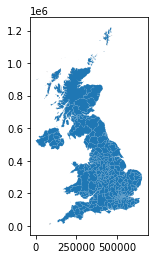

In [13]:
df.plot()

In [15]:
# find na data
df.isna().sum()

OBJECTID                                                     9
LAD20CD                                                      9
LAD20NM                                                      9
LAD20NMW                                                   366
BNG_E                                                        9
                                                          ... 
method_of_travel_to_work_passenger_in_a_car_or_van          45
method_of_travel_to_work_bicycle                            45
method_of_travel_to_work_on_foot                            45
method_of_travel_to_work_other_method_of_travel_to_work     45
method_of_travel_to_work_not_in_employment                  45
Length: 106, dtype: int64

In [19]:
# census data missing geography
df[df['LAD20NM'].isnull()][['geography_code','geography']]

,geography_code,geography
379,E07000201,Forest Heath
380,E07000204,St Edmundsbury
381,E07000206,Waveney
382,E07000004,Aylesbury Vale
383,E07000005,Chiltern
384,E07000006,South Bucks
385,E07000007,Wycombe
386,E07000051,Purbeck
387,E07000053,Weymouth and Portland


In [26]:
# geography missing census data
df[df['geography_code'].isnull() & ((df['LAD20CD'].str.startswith('E')) | (df['LAD20CD'].str.startswith('W')))]

,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,method_of_travel_to_work_train,method_of_travel_to_work_bus_minibus_or_coach,method_of_travel_to_work_taxi,method_of_travel_to_work_motorcycle_scooter_or_moped,method_of_travel_to_work_driving_a_car_or_van,method_of_travel_to_work_passenger_in_a_car_or_van,method_of_travel_to_work_bicycle,method_of_travel_to_work_on_foot,method_of_travel_to_work_other_method_of_travel_to_work,method_of_travel_to_work_not_in_employment
49,50.0,E06000053,Isles of Scilly,None,91327.0,11447.0,-6.30217,49.923321,1.631775e+07,117979.580176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,57.0,E06000060,Buckinghamshire,None,482506.0,208561.0,-0.80569,51.769661,1.564949e+09,361853.598103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# create buckinghamshire data
census_bucks = census_df[census_df['geography_code'].isin(['E07000004', 'E07000005', 'E07000006', 'E07000007'])].sum()
census_bucks['geography'] = 'Buckinghamshire'
census_bucks['geography_code'] = 'E06000060'
#census_bucks.tolist()

# reset the dataframe
census_df = pd.read_csv("districtCensusData.csv")
census_df.loc[-1] = census_bucks
census_df.index = census_df.index + 1
census_df

,geography,geography_code,dwelling_type_all_categories_accommodation_type,dwelling_type_unshared_dwelling_total,dwelling_type_unshared_dwelling_whole_house_or_bungalow_total,dwelling_type_unshared_dwelling_whole_house_or_bungalow_detached,dwelling_type_unshared_dwelling_whole_house_or_bungalow_semi-detached,dwelling_type_unshared_dwelling_whole_house_or_bungalow_terraced_(including_end-terrace),dwelling_type_unshared_dwelling_flat_maisonette_or_apartment_total,dwelling_type_unshared_dwelling_flat_maisonette_or_apartment_purpose-built_block_of_flats_or_tenement,...,method_of_travel_to_work_train,method_of_travel_to_work_bus_minibus_or_coach,method_of_travel_to_work_taxi,method_of_travel_to_work_motorcycle_scooter_or_moped,method_of_travel_to_work_driving_a_car_or_van,method_of_travel_to_work_passenger_in_a_car_or_van,method_of_travel_to_work_bicycle,method_of_travel_to_work_on_foot,method_of_travel_to_work_other_method_of_travel_to_work,method_of_travel_to_work_not_in_employment
1,Darlington,E06000005,104111.0,103979.0,95581.0,20750.0,42278,32553,8334.0,6748,...,862,3430.0,441,193,30531.0,3400.0,1170,6625,309.0,27621.0
2,County Durham,E06000047,500288.0,500209.0,481791.0,108279.0,187338,186174,17940.0,13491,...,1948,13963.0,1521,1061,154210.0,17707.0,2243,23797,1471.0,155902.0
3,Hartlepool,E06000001,91091.0,91063.0,84220.0,17724.0,31926,34570,6703.0,5739,...,481,2592.0,700,180,23871.0,3214.0,723,4514,414.0,29037.0
4,Middlesbrough,E06000002,136156.0,135987.0,125261.0,21120.0,58589,45552,10687.0,8972,...,718,4975.0,957,197,32508.0,4745.0,1397,7063,637.0,46004.0
5,Northumberland,E06000057,310591.0,310554.0,288741.0,86610.0,116600,85531,21362.0,16260,...,1952,7711.0,588,704,96053.0,9552.0,2137,16924,1411.0,86323.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,East Suffolk,E07000244,60895.5,60847.5,56914.5,28714.5,18546,9654,3591.5,2623,...,628,702.5,68,324,19449.5,1246.5,1356,2795,171.5,14996.5
341,West Suffolk,E07000245,60895.5,60847.5,56914.5,28714.5,18546,9654,3591.5,2623,...,628,702.5,68,324,19449.5,1246.5,1356,2795,171.5,14996.5
342,"Bournemouth, Christchurch and Poole",E06000058,371539.0,368979.0,268020.0,150964.0,75547,41509,100118.0,69998,...,3160,12393.0,548,2300,112191.0,9267.0,8702,20906,1239.0,95414.0
343,Cornwall,E06000052,525555.0,525021.0,474629.0,208536.0,143082,123011,44978.0,29764,...,2464,5961.0,743,2909,157998.0,12931.0,4159,34619,2472.0,144642.0


In [54]:
df = ladf.merge(census_df, how='outer', left_on='LAD20CD', right_on='geography_code')
df.head()

,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,method_of_travel_to_work_train,method_of_travel_to_work_bus_minibus_or_coach,method_of_travel_to_work_taxi,method_of_travel_to_work_motorcycle_scooter_or_moped,method_of_travel_to_work_driving_a_car_or_van,method_of_travel_to_work_passenger_in_a_car_or_van,method_of_travel_to_work_bicycle,method_of_travel_to_work_on_foot,method_of_travel_to_work_other_method_of_travel_to_work,method_of_travel_to_work_not_in_employment
0,1.0,E06000001,Hartlepool,None,447160.0,531474.0,-1.27018,54.676140,9.371263e+07,71007.443285,...,481.0,2592.0,700.0,180.0,23871.0,3214.0,723.0,4514.0,414.0,29037.0
1,2.0,E06000002,Middlesbrough,None,451141.0,516887.0,-1.21099,54.544670,5.388156e+07,44481.691242,...,718.0,4975.0,957.0,197.0,32508.0,4745.0,1397.0,7063.0,637.0,46004.0
2,3.0,E06000003,Redcar and Cleveland,None,464361.0,519597.0,-1.00608,54.567520,2.450695e+08,96703.989701,...,1193.0,3372.0,414.0,259.0,37919.0,4054.0,894.0,5731.0,733.0,42823.0
3,4.0,E06000004,Stockton-on-Tees,None,444940.0,518183.0,-1.30664,54.556911,2.049330e+08,123408.985928,...,1166.0,5115.0,642.0,417.0,60422.0,6160.0,1715.0,7518.0,1018.0,53532.0
4,5.0,E06000005,Darlington,None,428029.0,515648.0,-1.56835,54.535339,1.974757e+08,107206.401677,...,862.0,3430.0,441.0,193.0,30531.0,3400.0,1170.0,6625.0,309.0,27621.0


In [55]:
df[df['geography_code'].isnull() & ((df['LAD20CD'].str.startswith('E')) | (df['LAD20CD'].str.startswith('W')))]

,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,method_of_travel_to_work_train,method_of_travel_to_work_bus_minibus_or_coach,method_of_travel_to_work_taxi,method_of_travel_to_work_motorcycle_scooter_or_moped,method_of_travel_to_work_driving_a_car_or_van,method_of_travel_to_work_passenger_in_a_car_or_van,method_of_travel_to_work_bicycle,method_of_travel_to_work_on_foot,method_of_travel_to_work_other_method_of_travel_to_work,method_of_travel_to_work_not_in_employment
49,50.0,E06000053,Isles of Scilly,None,91327.0,11447.0,-6.30217,49.923321,1.631775e+07,117979.580176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
